In [19]:
import dataclasses

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor

In [15]:
@dataclasses.dataclass
class Data:
    train: pd.DataFrame
    test: pd.DataFrame

In [4]:
FILES = ('discounts_train.parq.gzip', 'discounts_test.parq.gzip')

sns.set_style("darkgrid")
pd.options.display.max_columns = 100

In [5]:
data = Data(
    train=pd.read_parquet(FILES[0]),
    test=pd.read_parquet(FILES[1])
)

In [6]:
data.train.head()

,spend_1m_baby,spend_2m_baby,spend_3m_baby,spend_4m_baby,spend_5m_baby,spend_6m_baby,spend_1m_clothes,spend_2m_clothes,spend_3m_clothes,spend_4m_clothes,spend_5m_clothes,spend_6m_clothes,spend_1m_health,spend_2m_health,spend_3m_health,spend_4m_health,spend_5m_health,spend_6m_health,spend_1m_pet,spend_2m_pet,spend_3m_pet,spend_4m_pet,spend_5m_pet,spend_6m_pet,spend_1m_groceries,spend_2m_groceries,spend_3m_groceries,spend_4m_groceries,spend_5m_groceries,spend_6m_groceries,spend_1m_eletronic,spend_2m_eletronic,spend_3m_eletronic,spend_4m_eletronic,spend_5m_eletronic,spend_6m_eletronic,sales,discount,profit,age,gender,cust_state,tenure,sales_prediction_bins,sales_prediction
0,0,0,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,45,15,30.0,55.0,10.0,160.0,0,0,0,0.0,0.0,0.0,3368.64,125.0,40.06,40,1.0,MA,6,8,1351.024765
1,0,0,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,5,5,0.0,0.0,10.0,0.0,0,0,0,0.0,0.0,0.0,2133.10,75.0,29.52,36,0.0,MG,10,4,1035.580387
2,0,0,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,25,30,35.0,0.0,20.0,50.0,0,0,0,0.0,0.0,0.0,2001.62,50.0,48.08,34,0.0,RJ,7,3,992.401825
3,0,0,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,55,135,120.0,10.0,40.0,130.0,0,0,0,0.0,0.0,0.0,1461.96,10.0,61.64,31,0.0,BA,7,1,919.720735
4,0,0,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,25,0,10.0,95.0,25.0,20.0,0,0,0,0.0,0.0,0.0,2743.72,100.0,34.44,32,1.0,PB,6,6,1176.485681


In [10]:
avg_sales_per_state = data.train.groupby('cust_state')['sales'].mean().to_dict()

In [13]:
data.train.replace({'cust_state': avg_sales_per_state}, inplace=True)
data.train.head()

,spend_1m_baby,spend_2m_baby,spend_3m_baby,spend_4m_baby,spend_5m_baby,spend_6m_baby,spend_1m_clothes,spend_2m_clothes,spend_3m_clothes,spend_4m_clothes,spend_5m_clothes,spend_6m_clothes,spend_1m_health,spend_2m_health,spend_3m_health,spend_4m_health,spend_5m_health,spend_6m_health,spend_1m_pet,spend_2m_pet,spend_3m_pet,spend_4m_pet,spend_5m_pet,spend_6m_pet,spend_1m_groceries,spend_2m_groceries,spend_3m_groceries,spend_4m_groceries,spend_5m_groceries,spend_6m_groceries,spend_1m_eletronic,spend_2m_eletronic,spend_3m_eletronic,spend_4m_eletronic,spend_5m_eletronic,spend_6m_eletronic,sales,discount,profit,age,gender,cust_state,tenure,sales_prediction_bins,sales_prediction
0,0,0,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,45,15,30.0,55.0,10.0,160.0,0,0,0,0.0,0.0,0.0,3368.64,125.0,40.06,40,1.0,2579.424297,6,8,1351.024765
1,0,0,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,5,5,0.0,0.0,10.0,0.0,0,0,0,0.0,0.0,0.0,2133.10,75.0,29.52,36,0.0,2553.222774,10,4,1035.580387
2,0,0,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,25,30,35.0,0.0,20.0,50.0,0,0,0,0.0,0.0,0.0,2001.62,50.0,48.08,34,0.0,2518.635848,7,3,992.401825
3,0,0,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,55,135,120.0,10.0,40.0,130.0,0,0,0,0.0,0.0,0.0,1461.96,10.0,61.64,31,0.0,2446.648394,7,1,919.720735
4,0,0,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,25,0,10.0,95.0,25.0,20.0,0,0,0,0.0,0.0,0.0,2743.72,100.0,34.44,32,1.0,2562.461439,6,6,1176.485681


In [23]:
unused = ['sales', 'discount', 'profit', 'sales_prediction']
keep = data.train.columns.drop(unused)
X = data.train[keep].fillna(0)
y = data.train['discount']

In [24]:
debias_pl = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', RFECV(estimator=LinearRegression())),
    ('estimator', GradientBoostingRegressor()),
])

debias_pl.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('feature_selection', RFECV(estimator=LinearRegression())),
                ('estimator', GradientBoostingRegressor())])

In [25]:
debias_resid = data.train['discount'] - debias_pl.predict(X)

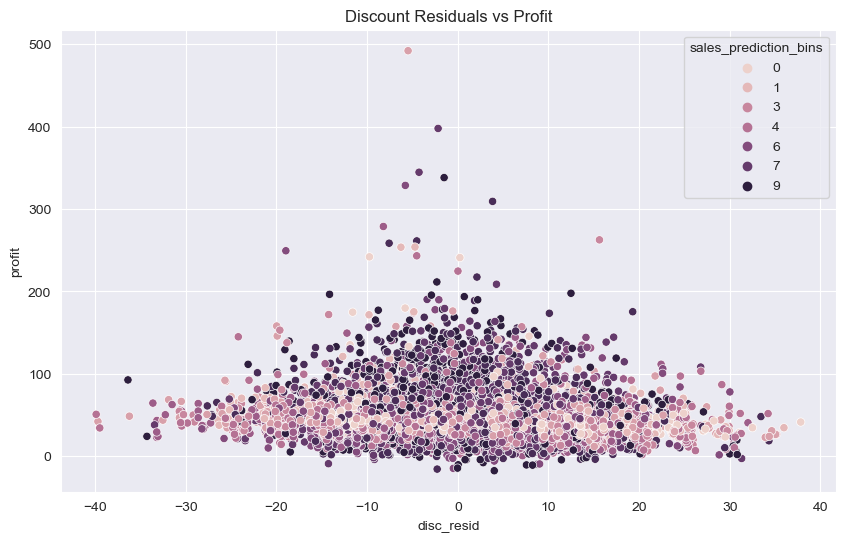

In [26]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.scatterplot(
    x='disc_resid', 
    y='profit',
    data=data.train.assign(disc_resid=debias_resid),
    hue='sales_prediction_bins',
    ax=ax
)
plt.title(f'Discount Residuals vs Profit')
plt.show()

In [52]:
unused = ['sales', 'discount', 'profit', 'sales_prediction']

keep = data.train.columns.drop(unused)
X = data.train[keep].fillna(0)
y = data.train['profit']

In [53]:
denoise_pl = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', RFECV(estimator=LinearRegression())),
    ('estimator', GradientBoostingRegressor()),
])

denoise_pl.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('feature_selection', RFECV(estimator=LinearRegression())),
                ('estimator', GradientBoostingRegressor())])

In [54]:
denoise_resid = data.train['profit'] - denoise_pl.predict(X)

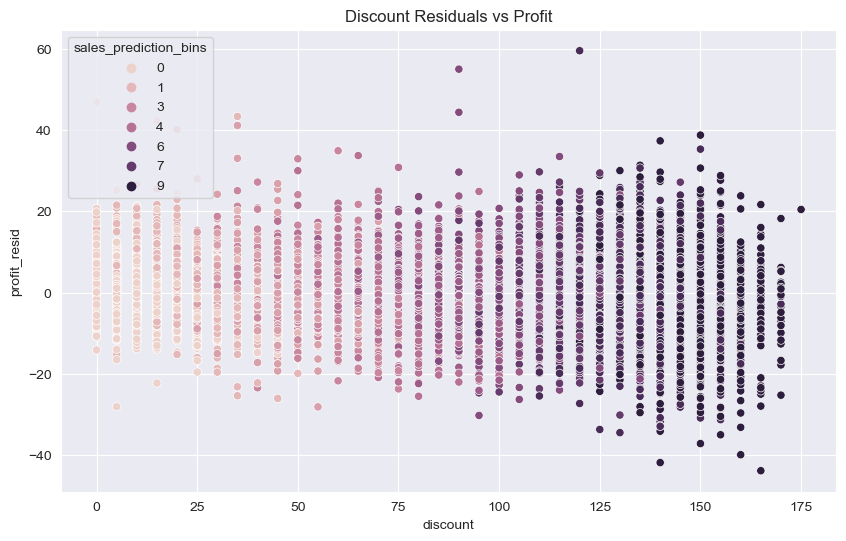

In [55]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.scatterplot(
    x='discount', 
    y='profit_resid',
    data=data.train.assign(profit_resid=denoise_resid),
    hue='sales_prediction_bins',
    ax=ax
)
plt.title(f'Discount Residuals vs Profit')
plt.show()

In [56]:
final_fit = smf.ols(
    'profit_resid ~ discount_resid',
    data=data.train.assign(
        discount_resid=debias_resid,
        profit_resid=denoise_resid
    )
).fit()

final_fit.summary()    

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           profit_resid   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     1246.
Date:                Tue, 20 Dec 2022   Prob (F-statistic):          2.77e-262
Time:                        14:04:26   Log-Likelihood:                -51623.
No. Observations:               15000   AIC:                         1.032e+05
Df Residuals:                   14998   BIC:                         1.033e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       2.033e-15      0.062   3.29e-14      1.000      -0.121       0.121
discount_resid    -0.2241      0.006    -35.300      0.000      -0.237      -0.212
==============================================================================
Omnibus:                      745.160   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2618.736
Skew:                           0.121   Prob(JB):                         0.00
Kurtosis:                       5.033   Cond. No.                         9.72
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

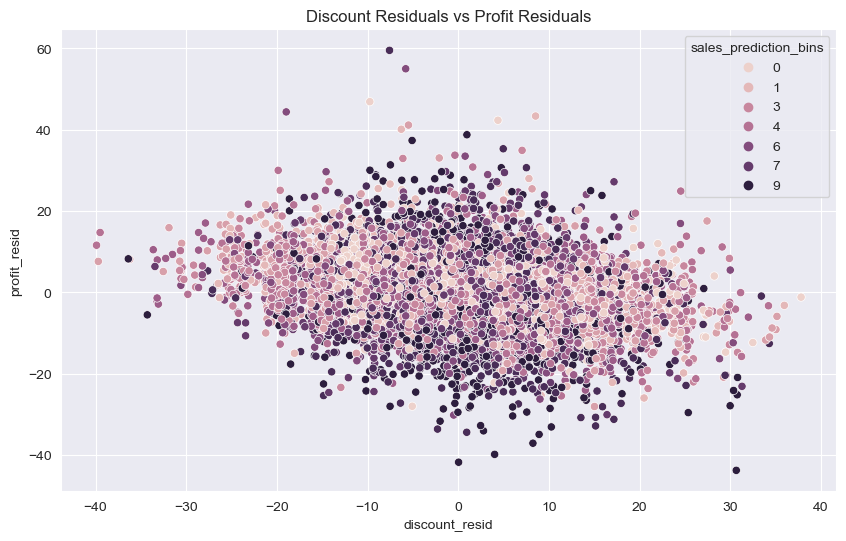

In [57]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.scatterplot(
    x='discount_resid', 
    y='profit_resid',
    data=data.train.assign(
        discount_resid=debias_resid,
        profit_resid=denoise_resid),
    hue='sales_prediction_bins',
    ax=ax
)
plt.title(f'Discount Residuals vs Profit Residuals')
plt.show()

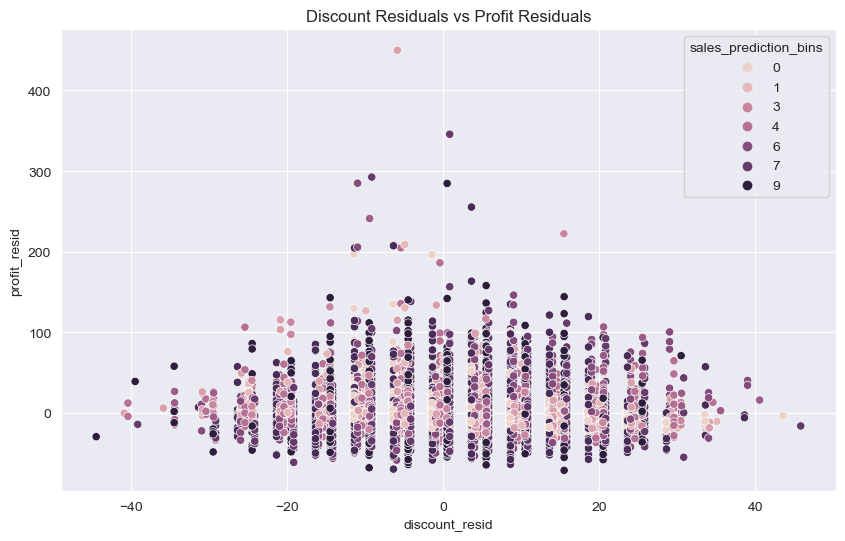

In [30]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.scatterplot(
    x='discount_resid', 
    y='profit_resid',
    data=data.train.assign(
        discount_resid=debias_model.resid,
        profit_resid=denoise_model.resid),
    hue='sales_prediction_bins',
    ax=ax
)
plt.title(f'Discount Residuals vs Profit Residuals')
plt.show()

In [66]:
pd.DataFrame(debias_resid).to_parquet('debias_resid.parq.gzip')
pd.DataFrame(denoise_resid).to_parquet('denoise_resid.parq.gzip')